In [56]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, AveragePooling2D, Flatten, Dense, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import TruePositives, FalsePositives, TrueNegatives, FalseNegatives, Precision, Recall, AUC, BinaryAccuracy
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve
import sklearn
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, CSVLogger
from sklearn.utils import class_weight
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

MULTISCALE FEATURE EXTRACTION LAYER

In [57]:
def multiscale_feature_extraction(x):
    # Branch 1
    branch1 = tf.keras.layers.Conv2D(filters=32, kernel_size=(1, 1), activation='relu', padding='same')(x)
    branch1 = tf.keras.layers.BatchNormalization()(branch1)

    # Branch 2
    branch2 = tf.keras.layers.Conv2D(filters=32, kernel_size=(1, 1), activation='relu', padding='same')(x)
    branch2 = tf.keras.layers.BatchNormalization()(branch2)
    branch2 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(branch2)
    branch2 = tf.keras.layers.BatchNormalization()(branch2)

    # Branch 3
    branch3 = tf.keras.layers.Conv2D(filters=32, kernel_size=(1, 1), activation='relu', padding='same')(x)
    branch3 = tf.keras.layers.BatchNormalization()(branch3)
    branch3 = tf.keras.layers.Conv2D(filters=32, kernel_size=(5, 5), activation='relu', padding='same')(branch3)
    branch3 = tf.keras.layers.BatchNormalization()(branch3)

    # Branch 4
    branch4 = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    branch4 = tf.keras.layers.BatchNormalization()(branch4)
    branch4 = tf.keras.layers.Conv2D(filters=32, kernel_size=(1, 1), activation='relu', padding='same')(branch4)
    branch4 = tf.keras.layers.BatchNormalization()(branch4)
    branch4 = tf.keras.layers.UpSampling2D(size=(2, 2))(branch4)

    merged_features = tf.keras.layers.concatenate([branch1, branch2, branch3, branch4], axis=-1)

    return merged_features

CHANNEL ATTENTION MECHANISM - SQUEEZE EXCITATION BLOCK

In [58]:
def squeeze_excite_block(x, reduction_ratio=16):
    channel_dim = x.shape[-1]
    squeeze = tf.keras.layers.GlobalAveragePooling2D()(x)

    units = channel_dim // reduction_ratio
    excitation = tf.keras.layers.Dense(units=units, activation='relu')(squeeze)
    
    excitation = tf.keras.layers.Dense(units=channel_dim, activation='sigmoid')(excitation)
    
    excitation = tf.reshape(excitation, (-1, 1, 1, channel_dim))
    
    x = x * excitation
    
    return x


IMPLICIT DEEP SUPERVISION LAYER

In [59]:
import tensorflow as tf

def basic_layer(x, growthrate):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Conv2D(filters=growthrate, kernel_size=(1,1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Conv2D(filters=growthrate, kernel_size=(1,1), padding='same')(x)
    return x

def dimension_reduction(x, out_channels):
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Conv2D(filters=out_channels, kernel_size=(1,1), padding='same')(x)
    x = tf.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=2)(x)
    return x

# Implicit Deep Supervision Module
def implicit_deep_supervision(x, input_feature_maps, growthrate=12):
    features = [x]

    # The Four basic layers
    for i in range(4):
        x = basic_layer(x, growthrate)
        features.append(x)
    
    # Concatenating all the features
    x = tf.concat(features, axis=-1)
    
    # Using the Dimension reduction function
    output_channels = input_feature_maps + 4 * growthrate
    x = dimension_reduction(x, output_channels)
    
    return x

MIDSNET MODEL

In [60]:
def MIDSNET():
    input_layer = Input((224, 224, 3))

    # Head Layers
    x = Conv2D(filters=32, kernel_size=(3, 3), strides=(2, 2), activation='relu', padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = Conv2D(filters=32, kernel_size=(3, 3), strides=(2, 2), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    # Multiscale Feature Extraction Layer
    for _ in range(3):
        x = multiscale_feature_extraction(x)
        x = BatchNormalization()(x)

    # Implicit Deep Supervision and Channel Attention Layers
    input_feature_maps = x.shape[-1]  # Finding the number of feature maps
    for i in range(4):
        x = implicit_deep_supervision(x, input_feature_maps=input_feature_maps)
        if i != 3:
            x = squeeze_excite_block(x)

    # Using upsampling before pooling so the size of the feature map can be large enough to undergo Averagepoolling
    x = UpSampling2D(size=(3, 3))(x)

    x = BatchNormalization()(x)
    x = AveragePooling2D(pool_size=(7, 7), strides=1)(x)
    x = Flatten()(x)

    output_layer = Dense(units=1, activation='sigmoid')(x)

 
    model = Model(inputs=input_layer, outputs=output_layer)

    optimizer = Adamax(
        learning_rate=0.001,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-08
    )

    metrics = [
        TruePositives(name='tp'),
        FalsePositives(name='fp'),
        TrueNegatives(name='tn'),
        FalseNegatives(name='fn'),
        Precision(name='precision'),
        Recall(name='recall'),
        AUC(name='auc'),
        BinaryAccuracy(name='accuracy')
    ]


    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=metrics)
    
    return model

GETTING THE DATASET

In [61]:
path_to_data = r'E:\all_images_preprocessed\train'


SPLITING THE DATASET

In [62]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    path_to_data,
    validation_split=0.3,
    subset='training',
    seed=123,
    image_size=(224,224),
    batch_size=32)

Found 28178 files belonging to 2 classes.
Using 19725 files for training.


In [63]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    path_to_data,
    validation_split=0.3,
    subset='validation',
    seed=123,
    image_size=(224,224),
    batch_size=32)

Found 28178 files belonging to 2 classes.
Using 8453 files for validation.


In [64]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    r'E:\all_images_preprocessed\test',
    image_size=(224,224),
    batch_size=32)

Found 3132 files belonging to 2 classes.


ADJUSTING THE CLASS WEIGHTS

In [65]:
y_train = np.concatenate([y for x, y in train_ds], axis=0)
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i : class_weights[i] for i in range(len(class_weights))}
class_weights

{0: 0.9447744036785133, 1: 1.062082705147534}

TRAINING THE MIDSNET MODEL

In [66]:
model = MIDSNET()
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.0001)
with tf.device('/GPU:0'):
    history = model.fit(train_ds, epochs=50, validation_data=val_ds, callbacks = [reduce_lr], class_weight=class_weights)
    

Epoch 1/50
617/617 [==============================] - 180s 259ms/step - loss: 0.2294 - tp: 8564.0000 - fp: 1215.0000 - tn: 9224.0000 - fn: 722.0000 - precision: 0.8758 - recall: 0.9222 - auc: 0.9670 - accuracy: 0.9018 - val_loss: 0.3131 - val_tp: 4030.0000 - val_fp: 813.0000 - val_tn: 3550.0000 - val_fn: 60.0000 - val_precision: 0.8321 - val_recall: 0.9853 - val_auc: 0.9741 - val_accuracy: 0.8967 - lr: 0.0010
Epoch 2/50
617/617 [==============================] - 156s 252ms/step - loss: 0.0812 - tp: 9108.0000 - fp: 353.0000 - tn: 10086.0000 - fn: 178.0000 - precision: 0.9627 - recall: 0.9808 - auc: 0.9945 - accuracy: 0.9731 - val_loss: 0.0798 - val_tp: 3987.0000 - val_fp: 152.0000 - val_tn: 4211.0000 - val_fn: 103.0000 - val_precision: 0.9633 - val_recall: 0.9748 - val_auc: 0.9955 - val_accuracy: 0.9698 - lr: 0.0010
Epoch 3/50
617/617 [==============================] - 155s 251ms/step - loss: 0.0631 - tp: 9101.0000 - fp: 277.0000 - tn: 10162.0000 - fn: 185.0000 - precision: 0.9705 - rec

PERFORMANCE METRICS FOR BOTH TRAIN AND VALIDATION SETS

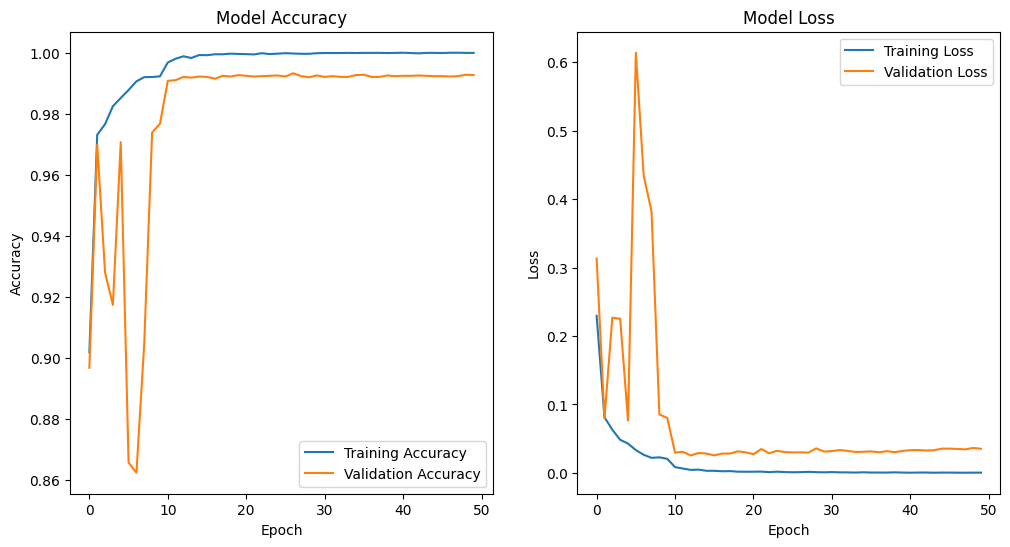

In [67]:
# Plot training & validation accuracy values
from matplotlib import pyplot as plt
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

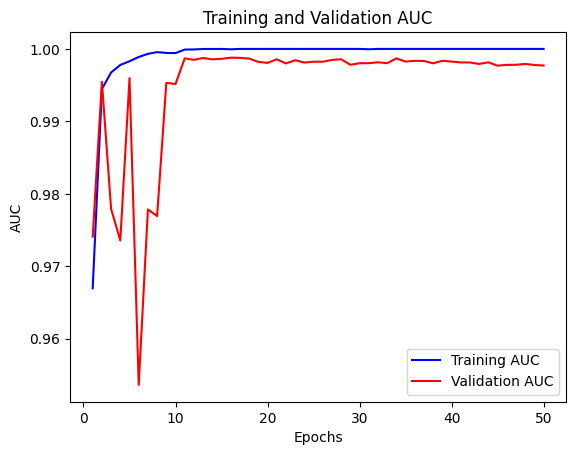

In [68]:
train_auc = history.history['auc']
val_auc = history.history['val_auc']
epochs = range(1, len(train_auc) + 1)

plt.plot(epochs, train_auc, 'b', label='Training AUC')
plt.plot(epochs, val_auc, 'r', label='Validation AUC')
plt.title('Training and Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.show()

EVALUATING THE TEST SET

In [69]:
model.evaluate(test_ds)

98/98 [==============================] - 18s 160ms/step - loss: 0.0522 - tp: 1481.0000 - fp: 19.0000 - tn: 1626.0000 - fn: 6.0000 - precision: 0.9873 - recall: 0.9960 - auc: 0.9971 - accuracy: 0.9920


[0.052162475883960724,
 1481.0,
 19.0,
 1626.0,
 6.0,
 0.987333357334137,
 0.9959650039672852,
 0.9971028566360474,
 0.9920178651809692]

PERFORMANCE METRICS FOR THE TEST SET

1/1 [==============================] - 3s 3s/step


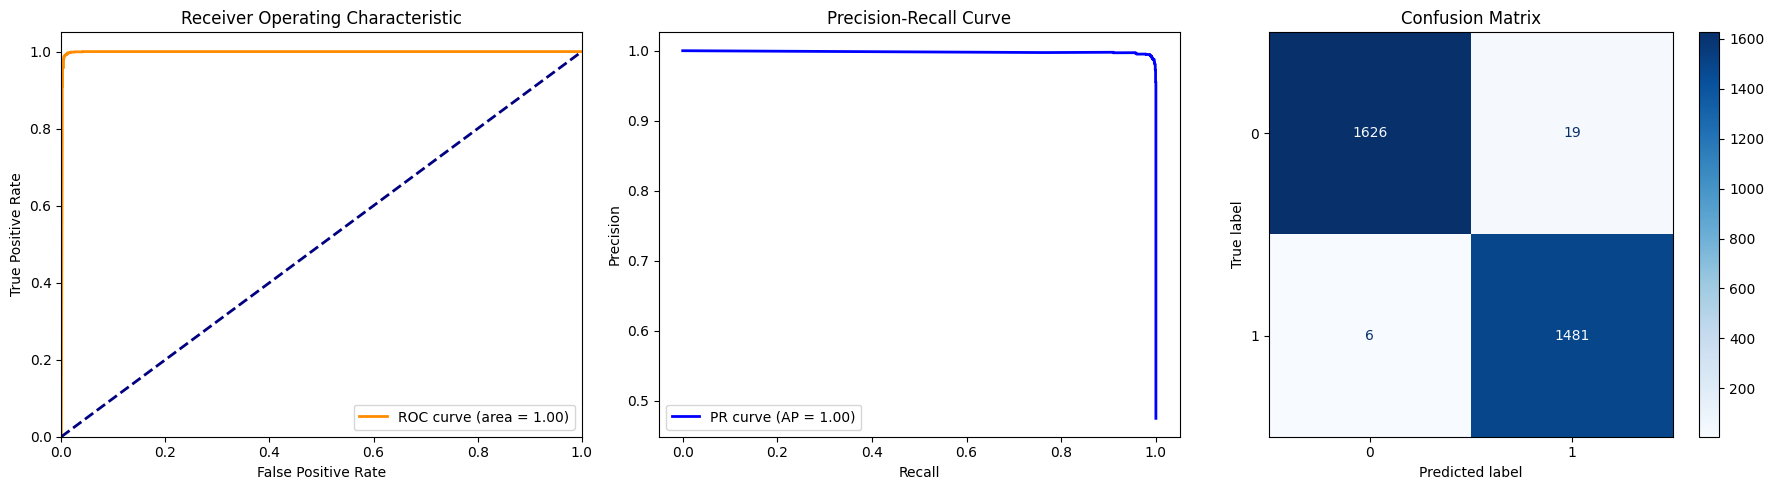

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf

def plot_metrics(model, test_data):
    # Collect true labels and predicted probabilities
    y_true = []
    y_pred_probs = []

    for images, labels in test_data:
        # Check if the images have an extra dimension and reshape them
        if len(images.shape) == 5:  # Shape is (1, batch_size, 224, 224, 3)
            images = tf.reshape(images, (-1, 224, 224, 3))  # Reshape to (batch_size, 224, 224, 3)

        # Convert tensors to numpy arrays if TensorFlow is in graph mode
        labels_np = labels.numpy() if tf.executing_eagerly() else tf.make_ndarray(labels)

        # Make predictions
        predictions = model.predict(images)

        # Flatten the true labels and predicted probabilities
        y_true.extend(labels_np.flatten())
        y_pred_probs.extend(predictions.flatten())

    # Convert to numpy arrays
    y_true = np.array(y_true)
    y_pred_probs = np.array(y_pred_probs)

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
    roc_auc = auc(fpr, tpr)

    # Compute Precision-Recall curve and average precision
    precision, recall, _ = precision_recall_curve(y_true, y_pred_probs)
    avg_precision = average_precision_score(y_true, y_pred_probs)

    # Compute the confusion matrix
    y_pred_labels = (y_pred_probs >= 0.5).astype(int)
    cm = confusion_matrix(y_true, y_pred_labels)

    # Plot ROC Curve
    plt.figure(figsize=(18, 5))

    plt.subplot(1, 3, 1)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")

    # Plot Precision-Recall Curve
    plt.subplot(1, 3, 2)
    plt.plot(recall, precision, color='b', lw=2, label='PR curve (AP = %0.2f)' % avg_precision)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")

    # Plot Confusion Matrix
    plt.subplot(1, 3, 3)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap=plt.cm.Blues, ax=plt.gca())
    plt.title('Confusion Matrix')

    plt.tight_layout()
    plt.show()


plot_metrics(model, test_ds)